# Get data

In [1]:
import requests
import zipfile
from pathlib import Path
import os
import matplotlib.pyplot as plt
import random
import numpy as np
from PIL import Image

# computer deep learning libraries
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)


    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        requests = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        f.write(requests.content)

    # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
            print("Unzipping pizza, steak, sushi data...") 
            zip_ref.extractall(image_path)



data/pizza_steak_sushi directory exists.


# Become one with data

In [3]:
# check how many images and folders are there by walking through the data
for dirpath, dirnames, filenames in os.walk(image_path, topdown=True):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.


In [4]:
train_dir = image_path / "train"
test_dir = image_path / "test"


#### Visualise Image


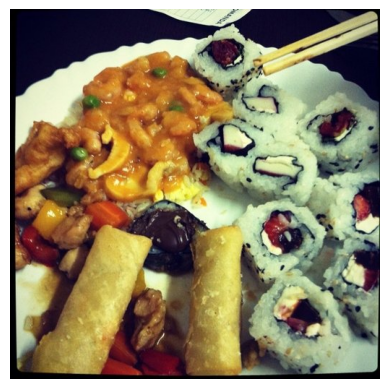

The shape of the image is (512, 512, 3)


In [5]:
torch.manual_seed(42)

# get all image paths
images_list = list(image_path.glob('*/*/*.jpg'))

# get a random path
random_image_path = random.choice(images_list)

# load the image
img = Image.open(random_image_path)

# convert the laoded image to numpyarray
np_array_image = np.asarray(img)

# plot the image 
plt.imshow(np_array_image)
plt.axis(False);
plt.show()

print(f"The shape of the image is {np_array_image.shape}")



# Transform Data

I've got folders of images but before I can use them with PyTorch, will need to convert them into tensors.

One of the ways to do this is by using the torchvision.transforms module.

torchvision.transforms contains many pre-built methods for formatting images, turning them into tensors and even manipulating them for data augmentation.

To get experience with torchvision.transforms, a series of transform steps that I would like to perform are:
<ul>
<li>Resize the images using transforms.Resize() (from about 512x512 to 64x64, the same shape as the images on the CNN Explainer website).</li>
<li>Flip the images randomly on the horizontal using transforms.RandomHorizontalFlip() (this could be considered a form of data augmentation because it will artificially change our image data).</li>
<li>Turn  images from a PIL image to a PyTorch tensor using transforms.ToTensor().</li>
<li>I can compile all of these steps using torchvision.transforms.Compose().</li>
</ul>

In [6]:
data_transformations = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

### OPTION 1 : Load Images with Image Folder

In [7]:
train_data = datasets.ImageFolder(root=train_dir, transform=data_transformations, target_transform=None)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transformations)

In [8]:
# get class names and indexes
class_names = train_data.classes
class_dict = train_data.class_to_idx

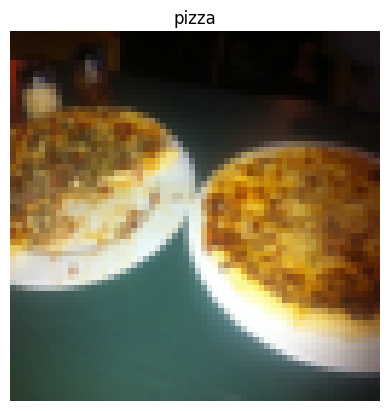

In [9]:
# Here the image is of dimension (C,H,W) to plot using matplot we need to change it to (H,W,C). 
# Cannot just queeze because squeeze can only remove all dimesnions of imput size 1. 
img, label = train_data[0]
img_permute = img.permute(1,2,0)
plt.imshow(img_permute)
plt.title(class_names[label])
plt.axis(False);
plt.show()

#### DataLoader

In [10]:
train_dataloader = DataLoader(dataset=train_data, batch_size=32, num_workers=1, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=32, num_workers=1, shuffle=False)

### OPTION 2 : Load Images with Custom Dataset

Steps:
<ul>
<li>traverse the target directory using scandir to get the class names</li>
<li>raise error if class names are not found</li>
<li>turn class names into a data dictionary</li>
<li>Create custom dataset to replicate ImageFolder. Steps are as follows</li>
    <ul>
    <li>Subclass torch.utils.data.Dataset.</li>
    <li>Initialize our subclass with a targ_dir parameter (the target data directory) and transform parameter (so we have the option to transform our data if needed).</li>
    <li>Create several attributes for paths (the paths of our target images), transform (the transforms we might like to use, this can be None), classes and class_to_idx (from our find_classes() function).</li>
    <li>Create a function to load images from file and return them, this could be using PIL or torchvision.io (for input/output of vision data).</li>
    <li>Overwrite the __len__ method of torch.utils.data.Dataset to return the number of samples in the Dataset, this is recommended but not required. This is so you can call len(Dataset).</li>
    <li>Overwrite the __getitem__ method of torch.utils.data.Dataset to return a single sample from the Dataset, this is required.</li>
    </ul>

</ul>

In [11]:
def find_classes(path:str):
    """Finds the class folder names in a target directory.
    
    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(path) if entry.is_dir())
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {path}.")
        
    # 3. Crearte a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    
    return classes, class_to_idx

find_classes(path=train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [12]:
from torch.utils.data import Dataset
# Write a custom dataset
class FoodImageDatasetCustom(Dataset):
    def __init__(self, targ_dir:str, transform = None) -> None:
        self.paths = list(targ_dir.glob('*/*.jpg'))

        self.transform = transform

        self.classes, self.class_to_idx = find_classes(targ_dir)

    def load_image(self, index:int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path)

    def __len__(self)-> int:
        return len(self.paths)
    
    def __getitem__(self, index: int):
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)
    


In [13]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [14]:
train_data_custom = FoodImageDatasetCustom(targ_dir=train_dir, transform=train_transforms)
test_data_custom = FoodImageDatasetCustom(targ_dir=test_dir, transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.FoodImageDatasetCustom at 0x7fd686442490>,
 <__main__.FoodImageDatasetCustom at 0x7fd686442850>)

In [15]:
# let's check the data
len(train_data_custom), len(test_data_custom)

(225, 75)

In [16]:
### check to see Dataset.ImageFolder vs CustomDataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)


True
True
True
